In [1]:
import sys
sys.path.append('..')

import os
root = os.getcwd()

import warnings
warnings.simplefilter("ignore")

In [17]:
from pathlib import Path
os.chdir(Path(root).parent.absolute())

In [18]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt


from src.data.ks_load import KeyStrokeDataLoader
from src.process.ks_process import KeyStrokeExtractor
from src.model.classifier import Trainer
from src.constants import DATA_PATH, SRC_PATH, REPORTS_PATH

In [19]:
# Settings
train_prop = 0.8
y_lbl = 'user'
seed = 9

### Loading and Visualization step
In this cell, we use the 'parser' to load the dataset into a dataframe structure

In [20]:
# Fetch dataset
loader = KeyStrokeDataLoader(path_or_buf=os.path.join(DATA_PATH, 'Train_keystroke.csv'))
ks_df = loader.load_df()  # data
print(ks_df)

     user  press-0  release-0  press-1  release-1  press-2  release-2  \
0       1        0        120      216        312      424        496   
1       1        0         95      168        265      360        455   
2       1        0         71      143        231      783        903   
3       1        0         95      144        263      353        431   
4       1        0         70      166        238      310        406   
..    ...      ...        ...      ...        ...      ...        ...   
875   110        0         80      225        306      444        465   
876   110        0         81      217        289      387        473   
877   110        0         79      216        300      393        519   
878   110        0         84      200        290      384        476   
879   110        0         64      271        366      424        510   

     press-3  release-3  press-4  ...  press-8  release-8  press-9  release-9  \
0        592        664      808  ...     

In [21]:
# Build keyboard typing performance aggregates
new_df = loader.get_aggregates_by_sentence().reset_index()


In [22]:
new_df

,index,user,actions,values
0,press-0,1,press-0,0
1,release-0,1,release-0,120
2,press-1,1,press-1,216
3,release-1,1,release-1,312
4,press-2,1,press-2,424
...,...,...,...,...
22875,release-10,110,release-10,1966
22876,press-11,110,press-11,1991
22877,release-11,110,release-11,2096
22878,press-12,110,press-12,2199


In [23]:
users, df_list = np.array(new_df.groupby(by='user', axis=0)).swapaxes(0, 1)

print(users)

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
 100 101 102 103 104 105 106 107 108 109 110]


c:\Users\matia\PycharmProjects\mlops_challenge\.pipenv\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


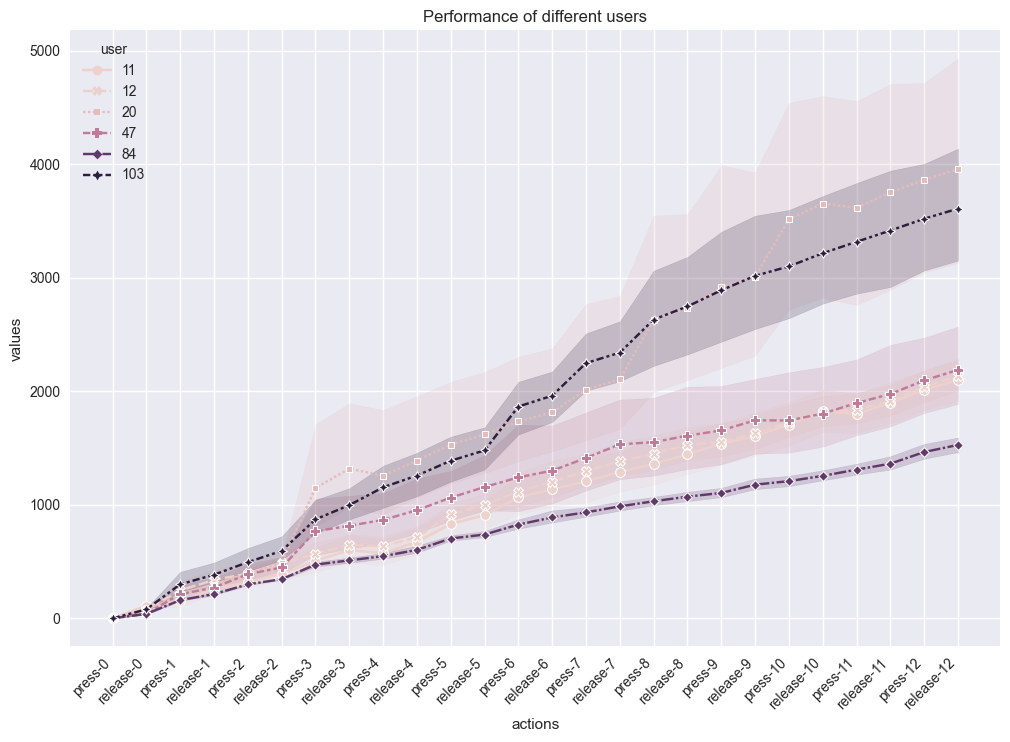

In [28]:
# Pick random users
pick_users = np.random.choice(np.arange(len(df_list)), size=6, replace=0)

# Define the dataframe to plot (only with a few Users) 
df_to_plot = pd.concat(df_list[pick_users])

# Visualization plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(data=df_to_plot, x='actions', y='values', hue='user', style='user', markers=True, dashes=True, ax=ax)
ax.set_title("Performance of different users")
plt.xticks(rotation=45, ha='right')
plt.style.use('seaborn')
plt.show()

Obs: By visual inspection, these time series are really distinguishable in terms of each one's progression rate (except the lightest). It may indicate that variability-based and differential-based features could tell us something useful about what distinguishes typing patterns amongst users. Need quantitative confirmation.

### Feature Extraction step
In this cell, we use the 'Extractor' parser to compute features over the key stroke data

In [25]:
# Extract Features
extractor = KeyStrokeExtractor(df=ks_df, y_lbl=y_lbl)
feat_df = extractor.build_feature_dataframe()
X_total, y_total = feat_df.drop([y_lbl], axis=1), feat_df[y_lbl]

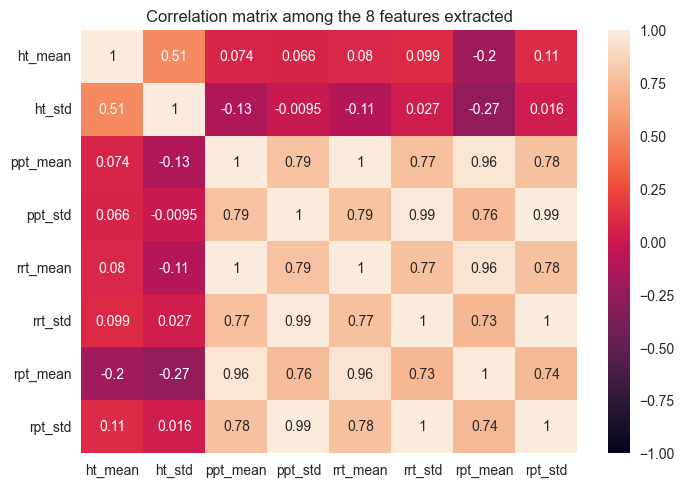

In [26]:
# Correlation amongst features extracted
corr = X_total.corr(method='pearson')

# Quick visualization of the pearson correlation matrix
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
ax.set_title("Correlation matrix among the 8 features extracted")
plt.show()

Obs: Eventually the number of features could be reduced without loss of performance from the model side. Nevertheless, it doesn't seem it would affect the inference stage (computationally speaking) given that the amount of features isn't extremelly high

In [27]:
# Final feature set (before splitting)
X_total

,ht_mean,ht_std,ppt_mean,ppt_std,rrt_mean,rrt_std,rpt_mean,rpt_std
0,72.000000,21.049392,229.333333,60.428102,225.333333,69.958718,157.333333,65.019655
1,70.384615,16.836492,185.916667,34.862727,182.000000,38.464269,113.666667,44.548351
2,80.307692,16.498879,239.250000,130.555943,237.916667,139.135700,156.833333,127.846805
3,72.000000,20.373437,331.916667,352.649604,330.000000,338.389568,259.916667,347.130249
4,74.769231,13.325244,173.833333,45.487788,176.000000,38.177218,100.833333,45.586609
...,...,...,...,...,...,...,...,...
875,111.307692,44.551413,190.333333,85.660506,202.000000,97.465378,88.083333,86.111806
876,103.076923,22.434388,213.416667,111.654570,218.583333,123.011828,113.666667,120.459767
877,123.615385,33.403221,191.916667,52.506283,197.500000,70.785474,70.166667,63.806783
878,108.230769,36.077169,181.166667,80.955578,186.250000,101.725222,76.000000,85.815694


In [13]:
# Let's generate a quick EDA analysis by using Sweetviz lib
#analyzing the dataset
X_report = sv.analyze(X_total)

#display the report
path = os.path.join(REPORTS_PATH, 'keystroke_features_eda.html')
if not os.path.exists(path):
    X_report.show_html(path)

                                             |          | [  0%]   00:00 -> (? left)

Report keystroke_feature_set.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Splitting step
We split the datasets to get any way of measuring performance differences amongst the different models

In [14]:
# Splitting into Train/Val sets
X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, train_size=train_prop, random_state=seed, stratify=y_total)

In [15]:
# Fine-tune estimators (RF, SVM, XGBoost by default)
predictor = Trainer()
predictor.fit_all(X_t=X_train, y_t=y_train)

2023-02-06 18:58:48.101 | DEBUG    | src.model.classifier:fit_all:43 - RF predictor successfully trained!
2023-02-06 18:58:48.470 | DEBUG    | src.model.classifier:fit_all:43 - SVM predictor successfully trained!


[18:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-02-06 18:58:50.961 | DEBUG    | src.model.classifier:fit_all:43 - XGB predictor successfully trained!
2023-02-06 18:58:50.961 | DEBUG    | src.model.classifier:fit_all:45 - Finished training


#### Evaluation step

In [16]:
# Evaluation 
rep = predictor.eval_all(X_v=X_val, y_v=y_val, to_save=True)

2023-02-06 18:58:51.074 | DEBUG    | src.model.classifier:save_estimator:92 - Estimator successfully dumped
2023-02-06 18:58:51.087 | DEBUG    | src.model.classifier:save_result:84 - Results successfully dumped
2023-02-06 18:58:51.088 | DEBUG    | src.model.classifier:eval_all:75 - RF predictor successfully trained!
2023-02-06 18:58:51.148 | DEBUG    | src.model.classifier:save_estimator:92 - Estimator successfully dumped
2023-02-06 18:58:51.150 | DEBUG    | src.model.classifier:save_result:84 - Results successfully dumped
2023-02-06 18:58:51.151 | DEBUG    | src.model.classifier:eval_all:75 - SVM predictor successfully trained!
2023-02-06 18:58:51.477 | DEBUG    | src.model.classifier:save_estimator:92 - Estimator successfully dumped
2023-02-06 18:58:51.478 | DEBUG    | src.model.classifier:save_result:84 - Results successfully dumped
2023-02-06 18:58:51.479 | DEBUG    | src.model.classifier:eval_all:75 - XGB predictor successfully trained!
2023-02-06 18:58:51.480 | DEBUG    | src.mod

Random Forest performance on the Validation set

In [35]:
RF_eval = pd.DataFrame(rep['RF'])

RF_eval

,1,2,3,4,5,6,7,8,9,10,...,104,105,106,107,108,109,110,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.021212,0.020833
recall,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.022727,0.022727
f1-score,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.021818,0.021591
support,2.0,2.0,1.0,1.0,2.000000,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.022727,176.000000,176.000000


Support Vector Machine performance on the Validation set

In [36]:
SVM_eval = pd.DataFrame(rep['SVM'])

SVM_eval

,1,2,3,4,5,6,7,8,9,10,...,104,105,106,107,108,109,110,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.003030,0.003788
recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.004545,0.005682
f1-score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.003636,0.004545
support,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.005682,176.000000,176.000000


XGBoost (Extreme Gradient Boosting) performance on the Validation set

In [37]:
XGB_eval = pd.DataFrame(rep['XGB'])

XGB_eval

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.004505,0.005682
recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.004505,0.005682
f1-score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005682,0.004505,0.005682
support,0.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.005682,176.000000,176.000000
